In [276]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
# Input data files are available in the "./input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("./input"))

# Any results you write to the current directory are saved as output.

['deceptive-opinion-spam-corpus', 'glove-global-vectors-for-word-representation', 'googles-trained-word2vec-model-in-python']


In [277]:
df = pd.read_csv('./input/deceptive-opinion-spam-corpus/deceptive-opinion.csv')

In [278]:
df.head()

,deceptive,hotel,polarity,source,text
0,truthful,conrad,positive,TripAdvisor,We stayed for a one night getaway with family ...
1,truthful,hyatt,positive,TripAdvisor,Triple A rate with upgrade to view room was le...
2,truthful,hyatt,positive,TripAdvisor,This comes a little late as I'm finally catchi...
3,truthful,omni,positive,TripAdvisor,The Omni Chicago really delivers on all fronts...
4,truthful,hyatt,positive,TripAdvisor,I asked for a high floor away from the elevato...


In [279]:
df = df.drop(["hotel", "polarity", "source"], axis=1)

In [280]:
df.head()

,deceptive,text
0,truthful,We stayed for a one night getaway with family ...
1,truthful,Triple A rate with upgrade to view room was le...
2,truthful,This comes a little late as I'm finally catchi...
3,truthful,The Omni Chicago really delivers on all fronts...
4,truthful,I asked for a high floor away from the elevato...


In [281]:
df1 = df.sample(frac=1)

In [282]:
df1.head()

,deceptive,text
157,truthful,I stayed for just one nite at the Sheraton Hot...
812,truthful,"The location of the hotel is great, right on t..."
1295,deceptive,After a one night stay at the Millennium Knick...
1214,deceptive,I will never stay at Conrad Chicago again. The...
790,deceptive,The Amalfi Hotel in Chicago is a wonderful hot...


In [283]:
from sklearn import preprocessing

# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'species'.
df1['deceptive'] = label_encoder.fit_transform(df1['deceptive'])

df1['deceptive'].unique()

array([1, 0])

In [284]:
df1.head()

,deceptive,text
157,1,I stayed for just one nite at the Sheraton Hot...
812,1,"The location of the hotel is great, right on t..."
1295,0,After a one night stay at the Millennium Knick...
1214,0,I will never stay at Conrad Chicago again. The...
790,0,The Amalfi Hotel in Chicago is a wonderful hot...


In [285]:
df1.describe()

,deceptive
count,1600.000000
mean,0.500000
std,0.500156
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [286]:
X = df1.text
y = df1.deceptive

In [287]:
# Some preprocesssing that will be common to all the text classification methods

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', '•',  '~', '@', '£',
          '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›',  '♥', '←', '×', '§', '″', '′', 'Â', '█', '½', 'à', '…',
          '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─',
          '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲', 'è', '¸', '¾', 'Ã', '⋅', '‘', '∞',
          '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√', ]


def clean_text(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x

In [288]:
def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

In [289]:
df1.head()

,deceptive,text
157,1,I stayed for just one nite at the Sheraton Hot...
812,1,"The location of the hotel is great, right on t..."
1295,0,After a one night stay at the Millennium Knick...
1214,0,I will never stay at Conrad Chicago again. The...
790,0,The Amalfi Hotel in Chicago is a wonderful hot...


In [290]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))


def clean_data(text):
    """
        text: a string

        return: modified initial string
    """
    text = BeautifulSoup(text, "lxml").text  # HTML decoding
    text = text.lower().split()
    text = " ".join(text)
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+\-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)

    return text


df1['text'] = df1['text'].apply(clean_data)

C:\Users\james\AppData\Local\Temp\ipykernel_25436\1265453582.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text  # HTML decoding


In [291]:
X = df1.text
y = df1.deceptive

In [292]:
X = X.map(lambda a: clean_data(a))

In [293]:
from __future__ import print_function
from keras.preprocessing.text import text_to_word_sequence
import pandas as pd
from keras.preprocessing.text import Tokenizer
import numpy as np
from bs4 import BeautifulSoup
import logging
from numpy import random
import gensim
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, MaxPooling1D, Flatten
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from keras import initializers, regularizers, constraints

In [294]:
train, test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

In [295]:
tokenizer = Tokenizer(num_words=None, lower=True,
                      filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', split=' ', char_level=False)

In [296]:
tokenizer.fit_on_texts(X)

In [297]:
x_train = tokenizer.texts_to_sequences(train)

In [298]:
x_test = tokenizer.texts_to_sequences(test)

In [299]:
word_index = tokenizer.word_index

In [300]:
X = tokenizer.texts_to_sequences(X)

In [301]:
vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in X)
print("Longest comment size: {}".format(longest))
average = np.mean([len(seq) for seq in X])
print("Average comment size: {}".format(average))
stdev = np.std([len(seq) for seq in X])
print("Stdev of comment size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max comment size: {}'.format(max_len))

Vocab size: 9635
Longest comment size: 795
Average comment size: 150.44875
Stdev of comment size: 88.50470254985042
Max comment size: 415


In [302]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [303]:
processed_post_x_train = pad_sequences(
    x_train, maxlen=max_len, padding='post', truncating='post')
processed_post_x_test = pad_sequences(
    x_test, maxlen=max_len, padding='post', truncating='post')

In [304]:
processed_x_train = pad_sequences(x_train, maxlen=max_len)
processed_x_test = pad_sequences(x_test, maxlen=max_len)

In [305]:
processed_pre_x_train = pad_sequences(x_train, maxlen=max_len)
processed_pre_x_test = pad_sequences(x_test, maxlen=max_len)

In [306]:
print('x_train shape:', processed_x_train.shape)
print('x_test shape:', processed_x_test.shape)

x_train shape: (1200, 415)
x_test shape: (400, 415)


In [307]:
from tensorflow.keras.layers import Layer

In [308]:
import keras.backend
from keras.models import Sequential, load_model
from keras.layers import CuDNNGRU, Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization, LSTM
from keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from keras.optimizers import Nadam
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

In [309]:
import os

In [310]:
embeddings_index = {}
f = open(os.path.join(
    './input/glove-global-vectors-for-word-representation', 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [311]:
embedding_dim = 100
k = 0
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        k += 1
        embedding_matrix[i] = embedding_vector

In [312]:
class Attention(Layer):
    def __init__(self, step_dim,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Example:
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
        """
        self.supports_masking = True
        # self.init = initializations.get('glorot_uniform')
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = step_dim
        self.features_dim = 0
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        # self.W = self.add_weight((input_shape[-1],),
        #                          initializer=self.init,
        #                          name='{}_W'.format(self.name),
        #                          regularizer=self.W_regularizer,
        #                          constraint=self.W_constraint)

        self.W = self.add_weight(
            shape=(input_shape[-1],),
            initializer=self.init,  # ensure `init` is set up as a valid initializer
            name="W",
            regularizer=self.W_regularizer,
            constraint=self.W_constraint
        )

        self.features_dim = input_shape[-1]

        if self.bias:
            # self.b = self.add_weight((input_shape[1],),
            #                          initializer='zero',
            #                           name='{}_b'.format(self.name),
            #                          regularizer=self.b_regularizer,
            #                          constraint=self.b_constraint)
            self.b = self.add_weight(
                shape=(input_shape[1],),
                # make surr `self.`sel` fs . vaind initialiali
    ti l      lizer=s.get('zeros'),
                initializer=initializers.get('zeros'),
                name="b",               # only one `name` argument
                regularizer=self.b_regularizer,
                constraint=self.b_constraint
            )

        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        # eij = K.dot(x, self.W) TF backend doesn't support it

        # features_dim = self.W.shape[0]
        # step_dim = x._keras_shape[1]

        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                        K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
    # print weigthted_input.shape
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        # return input_shape[0], input_shape[-1]
        return input_shape[0],  self.features_dim

In [313]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, concatenate
from tensorflow.keras.layers import concatenate
from keras.models import Model

In [314]:
import keras.backend
from keras.models import Sequential, load_model
from keras.layers import CuDNNGRU, Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization, LSTM
from keras.layers import Bidirectional
from tensorflow.keras.layers import Embedding
from keras.optimizers import Nadam
from keras.utils.vis_utils import plot_model
import matplotlib.pyplot as plt

In [315]:
from keras import backend as K

In [316]:
from tensorflow.keras.layers import AdditiveAttention

In [317]:
def get_model():
    review_input = Input(shape=(max_len,), dtype='int32')
    review_input_post = Input(shape=(max_len,), dtype='int32')

    # Use review_input here
    x1 = Embedding(vocab_size + 1, embedding_dim,
                   weights=[embedding_matrix], input_length=max_len, trainable=True)(review_input)
    x1 = Bidirectional(LSTM(60, return_sequences=True))(x1)
    x1 = Dropout(0.3)(x1)
    x1 = Attention(max_len)(x1)

    # Use review_input_post here
    x2 = Embedding(vocab_size + 1, embedding_dim, weights=[
                   embedding_matrix], input_length=max_len, trainable=True)(review_input_post)
    x2 = Bidirectional(LSTM(60, return_sequences=True))(x2)
    x2 = Dropout(0.3)(x2)
    x2 = Attention(max_len)(x2)

    x = concatenate([x1, x2])
    x = Dense(50, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    preds = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=[review_input, review_input_post], outputs=preds)

    model.compile(loss='binary_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    return model

In [318]:
model = get_model()

In [319]:
# from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dropout, Dense, BatchNormalization, Concatenate, AdditiveAttention
# from tensorflow.keras.models import Model


# def get_model():
#     # Define input layers
#     review_input = Input(shape=(max_len,), dtype='int32')
#     review_input_post = Input(shape=(max_len,), dtype='int32')

#     # Embedding and LSTM layers for the first input
#     x1 = Embedding(vocab_size + 1, embedding_dim,
#                    weights=[embedding_matrix], input_length=max_len, trainable=True)(review_input)
#     x1 = Bidirectional(LSTM(60, return_sequences=True))(x1)
#     x1 = Dropout(0.3)(x1)

#     # Embedding and LSTM layers for the second input
#     x2 = Embedding(vocab_size + 1, embedding_dim, weights=[
#                    embedding_matrix], input_length=max_len, trainable=True)(review_input_post)
#     x2 = Bidirectional(LSTM(60, return_sequences=True))(x2)
#     x2 = Dropout(0.3)(x2)

#     # Additive Attention layers for each input (using self-attention)
#     attention_layer_1 = AdditiveAttention()
#     # query and key-value pairs are the same for self-attention
#     x1 = attention_layer_1([x1, x1])

#     attention_layer_2 = AdditiveAttention()
#     # query and key-value pairs are the same for self-attention
#     x2 = attention_layer_2([x2, x2])

#     # Concatenate the outputs of both attention layers
#     x = Concatenate()([x1, x2])

#     # Dense layers
#     x = Dense(50, activation='relu')(x)
#     x = Dropout(0.2)(x)
#     x = BatchNormalization()(x)

#     # Output layer
#     preds = Dense(1, activation='sigmoid')(x)

#     # Build the model
#     model = Model(inputs=[review_input, review_input_post], outputs=preds)

#     # Compile the model
#     model.compile(loss='binary_crossentropy',
#                   optimizer='adam', metrics=['accuracy'])

#     return model

In [320]:
# model = get_model()

In [321]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_25 (InputLayer)          [(None, 415)]        0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 415)]        0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 415, 100)     963600      ['input_25[0][0]']               
                                                                                                  
 embedding_17 (Embedding)       (None, 415, 100)     963600      ['input_26[0][0]']               
                                                                                            

In [322]:
from keras.callbacks import ModelCheckpoint

In [323]:
# checkpoint
filepath = "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [324]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=10)

In [325]:
history = model.fit([processed_x_train, processed_pre_x_train], y_train, validation_data=(
    [processed_x_test, processed_pre_x_test], y_test), epochs=15, batch_size=32, callbacks=[early_stopping_monitor], verbose=1)

Epoch 1/15
38/38 [==============================] - 56s 1s/step - loss: 0.6855 - accuracy: 0.5617 - val_loss: 0.6789 - val_accuracy: 0.7275
Epoch 2/15
38/38 [==============================] - 50s 1s/step - loss: 0.5611 - accuracy: 0.7283 - val_loss: 0.6314 - val_accuracy: 0.7200
Epoch 3/15
38/38 [==============================] - 50s 1s/step - loss: 0.4622 - accuracy: 0.7833 - val_loss: 0.5655 - val_accuracy: 0.7225
Epoch 4/15
38/38 [==============================] - 50s 1s/step - loss: 0.3240 - accuracy: 0.8733 - val_loss: 0.4528 - val_accuracy: 0.7700
Epoch 5/15
38/38 [==============================] - 50s 1s/step - loss: 0.1901 - accuracy: 0.9375 - val_loss: 0.5588 - val_accuracy: 0.7325
Epoch 6/15
38/38 [==============================] - 50s 1s/step - loss: 0.1272 - accuracy: 0.9617 - val_loss: 0.6302 - val_accuracy: 0.7200
Epoch 7/15
38/38 [==============================] - 50s 1s/step - loss: 0.0891 - accuracy: 0.9725 - val_loss: 0.4005 - val_accuracy: 0.8275
Epoch 8/15
38/38 [==

In [326]:
model.save("normal.hdf5")

c:\Users\james\anaconda3\envs\idlf23\lib\site-packages\keras\engine\functional.py:1563: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


NotImplementedError: 
Layer Attention has arguments ['step_dim', 'W_regularizer', 'b_regularizer', 'W_constraint', 'b_constraint', 'bias']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config

In [77]:
model.evaluate([processed_x_test, processed_pre_x_test], y_test)

13/13 [==============================] - 11s 868ms/step - loss: 0.5808 - accuracy: 0.8545


[0.5807809233665466, 0.8545000553131104]

In [86]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

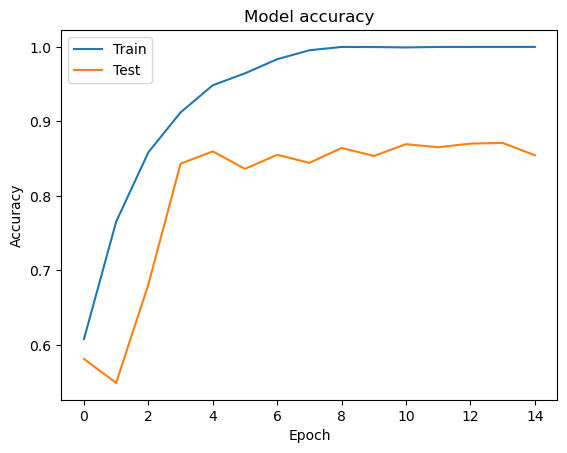

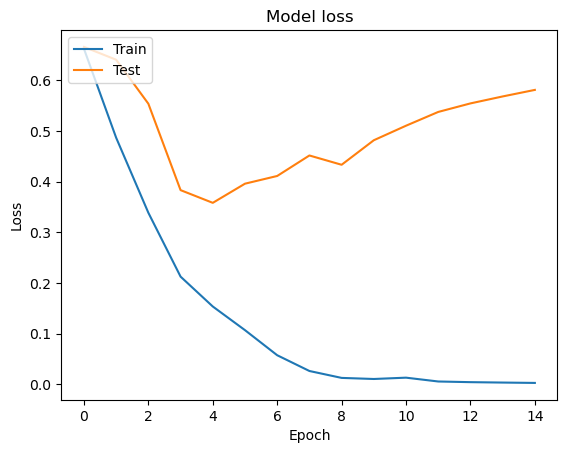

In [84]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()